# Python and the rest

The "rest" can be an external program, a remote program or a library made for a different language. To a certain degree all languages became good at accessing external resources but Python excels at it. We learned how to access remote APIs. We will only learn here how to deal with C and R.

### Python and C

There are ways to [extend Python with C and C++](https://docs.python.org/2/extending/extending.html), but it is cumbersome. There are different interpreters for Python, most popular being CPython which is the standard one and PyPy which is a just-in-time compiler and interpreter having speeds that match .js and Java. In principle the extension code needs to be re-written in order to run on different interpreters. 

Here is an example extension C code, written for the CPython interpreter. When compiled the spam function is callable from Python, so Python was extended with a new module.function():

```
static PyObject *
spam_system(PyObject *self, PyObject *args)
{
    const char *command;
    int sts;

    if (!PyArg_ParseTuple(args, "s", &command))
        return NULL;
    sts = system(command);
    return Py_BuildValue("i", sts);
}
```

**Enter [Cython](http://cython.org/).**

Cython is a static compiler that makes it possible to combine C with Python. It is heavily promoted and used by the Scipy stack and it can run on PyPy too. The following code is written in Cython, and as you can see it does differ in one substantial way to Python: variable are statically declared. Another major difference is that this code does not run on an interpreter, instead it is compiled into C and assembled in machine code. A similar project exists for Java, called Jython.

```
def primes(int kmax):  # The argument will be converted to int or raise a TypeError.
    cdef int n, k, i  # These variables are declared with C types.
    cdef int p[1000]  # Another C type
    result = []  # A Python type
    if kmax > 1000:
        kmax = 1000
    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i = i + 1
        if i == k:
            p[k] = n
            k = k + 1
            result.append(n)
        n = n + 1
    return result
```

**SWIG**

While Cython is cool, it does require you to write new code. If you have a C/C++ codebase and you want it in Python, perhaps the best option is SWIG. This is a multilanguage library, one can extend Tcl, Perl, Java and C# with it. Let's say you have the following pure C code containing a number of different functions:

```
/* File : example.c */
 
 #include <time.h>
 double My_variable = 3.0;
 
 int fact(int n) {
     if (n <= 1) return 1;
     else return n*fact(n-1);
 }
 
 int my_mod(int x, int y) {
     return (x%y);
 }
 	
 char *get_time()
 {
     time_t ltime;
     time(&ltime);
     return ctime(&ltime);
 }
```

All you have to do is write an interface of the code to SWIG:
```
/* example.i */
 %module example
 %{
 /* Put header files here or function declarations like below */
 extern double My_variable;
 extern int fact(int n);
 extern int my_mod(int x, int y);
 extern char *get_time();
 %}
 
 extern double My_variable;
 extern int fact(int n);
 extern int my_mod(int x, int y);
 extern char *get_time();
```

Run a sequence of commands that compiles and links the code with special SWIG signatures. This is slightly different depending on the OS, what you see is Unix/Linux modus operandi.

```
swig -python example.i
gcc -c example.c example_wrap.c -I/usr/local/include/python2.7
ld -shared example.o example_wrap.o -o _example.so 
```

On Python the result is a module like any other:

```
 >>> import example
 >>> example.fact(5)
 120
 >>> example.my_mod(7,3)
 1
 >>> example.get_time()
 'Sun Feb 11 23:01:07 1996'
```

### Talking to R

While some Python and R programmers don't talk to each other, the languages do. It is possible to call Python from R (rpy) and R from Python (rPython). From our perspective it is more natural to call R from Python, in fact the library is much more developed in this direction.

It requires a special module called rpy2. We will make use of R again in the 'omics chapters. For now let us use [this example](http://www2.warwick.ac.uk/fac/sci/moac/people/students/peter_cock/python/heatmap/) slightly modified for rpy2.
You can see the whole output from R and you can also interact with R environment through the execution.

But, how to get the required rpy2 module?

Google 'conda install rpy2' and feel lucky, the page at https://anaconda.org/r/rpy2 says:

```
conda install rpy2
```

This failed on my Ubuntu 64 bits system, it seems that Anaconda has problems maintaining it on the site. So I went to rpy2 homepage:

http://rpy2.bitbucket.org/

.. and I installed rpy2 with pip (Anaconda installs the pip package manager)

```
pip install rpy2
```

.. Yea, so this took me one hour last night to fix, but the problem was only affecting Linux and Anaconda. Only use import readline if you have Linux.

In [ ]:
import readline
import rpy2.robjects as robjects

robjects.r('''
source("http://www.bioconductor.org/biocLite.R")
biocLite("ALL")
library("ALL")
data("ALL")
#install.packages("gplots")
eset <- ALL[, ALL$mol.biol %in% c("BCR/ABL", "ALL1/AF4")]
library("limma")
f <- factor(as.character(eset$mol.biol))
design <- model.matrix(~f)
fit <- eBayes(lmFit(eset,design))
selected  <- p.adjust(fit$p.value[, 2]) <0.05
esetSel <- eset [selected, ]
color.map <- function(mol.biol) { if (mol.biol=="ALL1/AF4") "#FF0000" else "#0000FF" }
patientcolors <- unlist(lapply(esetSel$mol.bio, color.map))
#heatmap(exprs(esetSel), col=topo.colors(100), ColSideColors=patientcolors)
library("gplots")
heatmap.2(exprs(esetSel), col=redgreen(75), scale="row", ColSideColors=patientcolors,
           key=TRUE, symkey=FALSE, density.info="none", trace="none", cexRow=0.5)
''')


/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: Bioconductor version 3.2 (BiocInstaller 1.20.1), ?biocLite for help

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: BioC_mirror: http://bioconductor.org

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: Using Bioconductor 3.2 (BiocInstaller 1.20.1), R 3.2.4 Revised (2016-03-16
  r70336).

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: Installing package(s) ‘ALL’

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/




The downloaded source packages are in
	‘/tmp/RtmpKCmZkb/downloaded_packages’



Update all/some/none? [a/s/n]: 
a


/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: also installing the dependencies ‘AnnotationDbi’, ‘XML’, ‘RCurl’, ‘S4Vectors’, ‘IRanges’, ‘GenomeInfoDb’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘Biostrings’, ‘XVector’, ‘RSQLite’, ‘zlibbioc’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: trying URL 'http://bioconductor.org/packages/3.2/bioc/src/contrib/AnnotationDbi_1.32.3.tar.gz'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning:  length 4268480 bytes (4.1 MB)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: downloaded 4.1 MB







The downloaded source packages are in
	‘/tmp/RtmpKCmZkb/downloaded_packages’





/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: also installing the dependencies ‘curl’, ‘openssl’, ‘httr’, ‘pryr’, ‘gistr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: trying URL 'http://cran.rstudio.com/src/contrib/curl_0.9.7.tar.gz'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning:  length 263926 bytes (257 KB)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: downloaded 257 KB


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/sergiun/programs/anaconda3/envs/py35/lib/python3.5/site-packages/rpy2/robject

However in the example above there is no real communication between the two languages. Let us change that with another small example, in which we send a numpy matrix to R. Don't worry at this point about what numpy is, we will learn it in the scientific computing chapter.

In [3]:
import readline
import numpy as np
from rpy2.robjects import r
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

data = np.random.random((10,10))
r.heatmap(data)


<ListVector - Python:0x7f7610048c48 / R:0x2cfe3c0>
[IntVector, IntVector, RNULLType, RNULLType]
  rowInd: <class 'rpy2.robjects.vectors.IntVector'>
  <IntVector - Python:0x7f7610048b48 / R:0x2cfa040>
[       8,        9,       10, ...,        2,        5,        4]
  colInd: <class 'rpy2.robjects.vectors.IntVector'>
  <IntVector - Python:0x7f75ec7d59c8 / R:0x2e4c1d0>
[       2,        6,        7, ...,        1,        4,        8]
  Rowv: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL
  Colv: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL

All is well above, except the display happens in an external R GUI frame. It would be nice to have an inline plot, matplotlib style. Well guess what, you are in luck because IPython is also having native support for R. This is the recommended way in which Python and R can interact in the IPython notebook:

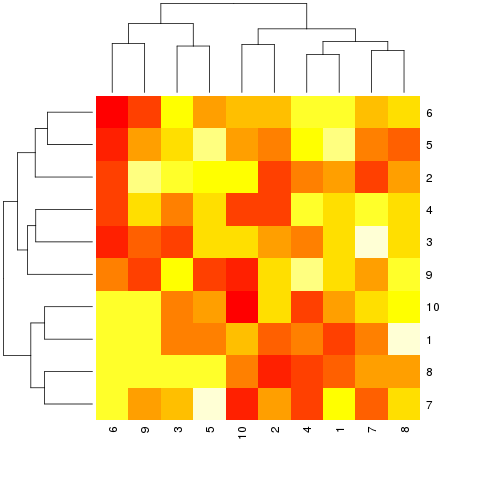

<ListVector - Python:0x7f761004a088 / R:0x2c40c00>
[IntVector, IntVector, RNULLType, RNULLType]
  rowInd: <class 'rpy2.robjects.vectors.IntVector'>
  <IntVector - Python:0x7f7604017348 / R:0x2cdadd0>
[       7,        8,        1, ...,        2,        5,        6]
  colInd: <class 'rpy2.robjects.vectors.IntVector'>
  <IntVector - Python:0x7f75ec7dcbc8 / R:0x2d11670>
[       6,        9,        3, ...,        1,        7,        8]
  Rowv: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL
  Colv: <class 'rpy2.rinterface.RNULLType'>
  rpy2.rinterface.NULL

In [5]:
#%load_ext rpy2.ipython
#from rpy2.robjects import r
#import rpy2.robjects.numpy2ri
#rpy2.robjects.numpy2ri.activate()

import numpy as np
data = np.random.random((10,10))

%Rpush data
%R heatmap(data)